<a href="https://colab.research.google.com/github/BohdanShepel2005/Mashynne-Navchannya/blob/main/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0_%D1%80%D0%BE%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%96_12_%D0%B7_%D0%9C%D0%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all messages, 3 = only errors
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


In [18]:
import kagglehub
moazeldsokyx_dogs_vs_cats_path = kagglehub.dataset_download('moazeldsokyx/dogs-vs-cats')

print('Data source import complete.')

100%|██████████| 817M/817M [00:11<00:00, 76.8MB/s]

Extracting files...


Data source import complete.


In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os

In [20]:
train_dir = moazeldsokyx_dogs_vs_cats_path+'/dataset/train'
val_dir = moazeldsokyx_dogs_vs_cats_path+'/dataset/validation'
test_dir =moazeldsokyx_dogs_vs_cats_path+'/dataset/test'

In [21]:
class_names = ['Cat', 'Dog']
# Генератор для тренування з аугментацією + нормалізацією для VGG16
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Генератор для валідації і тесту — тільки нормалізація
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Генератор для тренувального набору
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Рекомендований розмір для VGG16
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

# Генератор для валідаційного набору
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Генератор для тестового набору
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12461 images belonging to 2 classes.


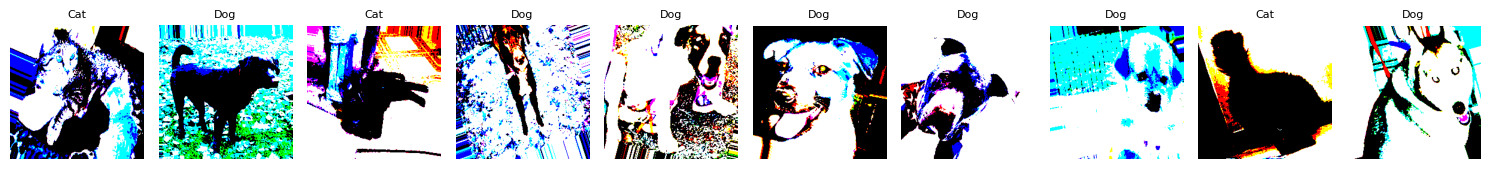

In [22]:
# Отримуємо новий набір зображень
images, labels = next(train_generator)

# Випадкові індекси для 10 зображень
indices = np.random.choice(len(images), size=10, replace=False)

# Візуалізація
plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices):
    plt.subplot(1, 10, i + 1)
    plt.imshow(images[idx])
    plt.axis('off')
    plt.title(class_names[int(labels[idx])], fontsize=8)
plt.tight_layout()
plt.show()



In [23]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,           # Ми додаємо свої класифікатори
    input_shape=(224, 224, 3)
)

# Заморожуємо всі шари базової VGG16
for layer in base_model.layers:
    layer.trainable = False

In [24]:


# Базова модель без "голови"
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

# Додаємо просту "голову"
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)


In [25]:
# Компіляція
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Короткий опис моделі
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,715,201 (56.13 MB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Слідкуємо за валідаційною втратою
    patience=5,               # Скільки епох чекати без покращення
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,               # Зменшення LR у 5 разів
    patience=3,               # Якщо за 3 епохи немає покращення
    min_lr=1e-6               # Мінімально допустимий learning rate
)

In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 352s 563ms/step - accuracy: 0.9580 - loss: 0.1207 - val_accuracy: 0.9750 - val_loss: 0.0825
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 301s 482ms/step - accuracy: 0.9733 - loss: 0.0731 - val_accuracy: 0.9788 - val_loss: 0.0746
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 322s 483ms/step - accuracy: 0.9779 - loss: 0.0606 - val_accuracy: 0.9828 - val_loss: 0.0614
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 322s 515ms/step - accuracy: 0.9793 - loss: 0.0536 - val_accuracy: 0.9832 - val_loss: 0.0573
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 306s 489ms/step - accuracy: 0.9808 - loss: 0.0531 - val_accuracy: 0.9802 - val_loss: 0.0698


390/390 ━━━━━━━━━━━━━━━━━━━━ 63s 159ms/step - accuracy: 0.7609 - loss: 0.9378
Test accuracy: 69.01%


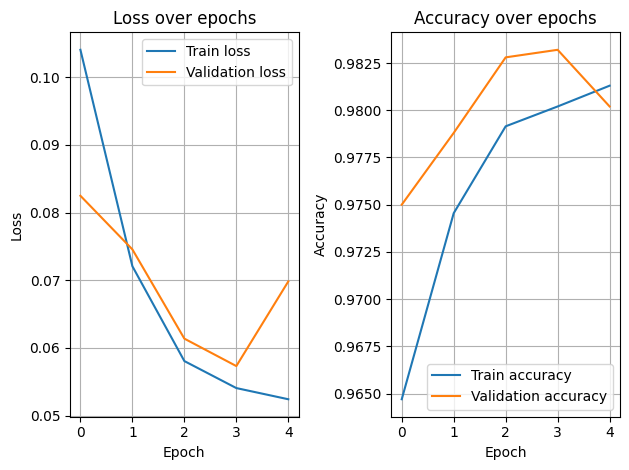

In [26]:
loss, acc = model.evaluate(test_generator, steps=len(test_generator))

print(f"Test accuracy: {acc:.2%}")

plt.subplot(1, 2, 1)

plt.plot(history.history['loss'], label='Train loss')

plt.plot(history.history['val_loss'], label='Validation loss')

plt.title('Loss over epochs')

plt.grid()

plt.xlabel('Epoch')

plt.ylabel('Loss')

plt.legend()

# Криві точності

plt.subplot(1, 2, 2)

plt.plot(history.history['accuracy'], label='Train accuracy')

plt.plot(history.history['val_accuracy'], label='Validation accuracy')

plt.title('Accuracy over epochs')

plt.xlabel('Epoch')

plt.ylabel('Accuracy')

plt.grid()

plt.legend()

plt.tight_layout()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step


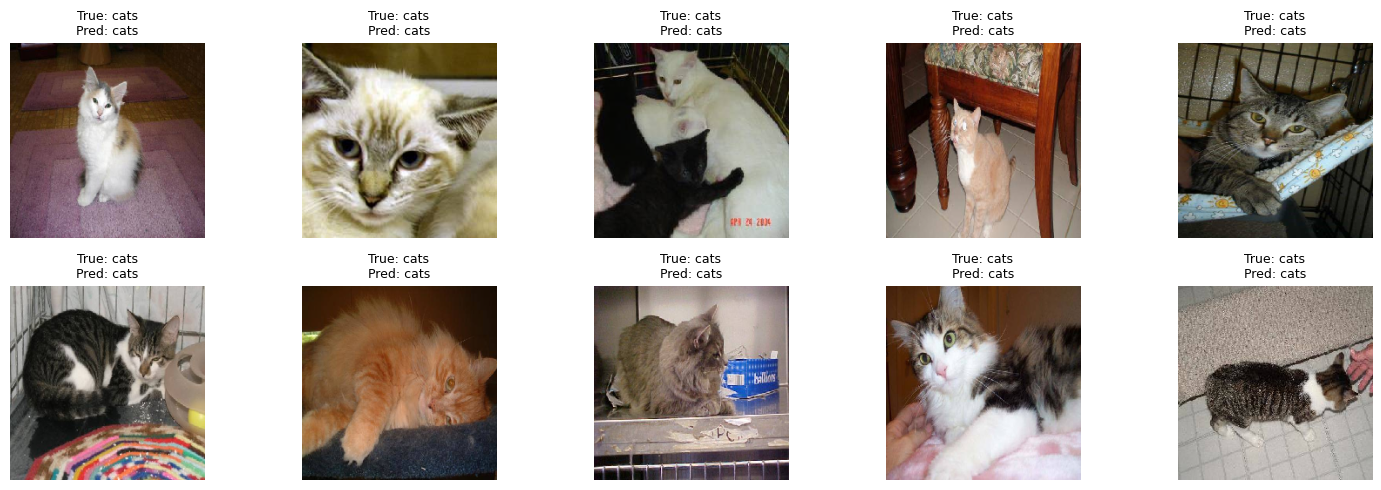

In [36]:
# Повертаємо генератор у початок (на всяк випадок)
test_generator.reset()

# Отримуємо один batch із тестового генератора
images, true_labels = next(test_generator)

# Робимо передбачення
pred_probs = model.predict(images)
pred_labels = (pred_probs > 0.5).astype(int).reshape(-1)

# Отримуємо відповідність індексів класів
inv_class_indices = {v: k for k, v in test_generator.class_indices.items()}
class_names = [inv_class_indices[0], inv_class_indices[1]]  # ['Cat', 'Dog']

# Показуємо перші 10 зображень
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Зображення після VGG16-preprocessing будуть зі зміненими значеннями
    # Повертаємо до нормального вигляду, якщо потрібно
    img = images[i].copy()
    img = img + [103.939, 116.779, 123.68]  # додаємо mean (VGG16)
    img = img[..., ::-1]  # з BGR → RGB
    img = np.clip(img / 255.0, 0, 1)  # для відображення

    plt.imshow(img)
    plt.axis('off')
    true_class = class_names[int(true_labels[i])]
    pred_class = class_names[int(pred_labels[i])]
    plt.title(f"True: {true_class}\nPred: {pred_class}", fontsize=9)
plt.tight_layout()
plt.show()

У роботі реалізовано класифікацію зображень котів і собак за допомогою моделі VGG16. Підготовлено дані, застосовано аугментацію, додано власні шари класифікації. Модель навчено та оцінено точність. Отримано базові навички transfer learning.

Другий варіант тюнинг моделі

In [28]:
# Завантаження базової VGG16 без класифікатора
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

#  Заморожуємо тільки нижні шари, а верхні розморозимо для fine-tuning
for layer in base_model.layers[:15]:
    layer.trainable = False
for layer in base_model.layers[15:]:
    layer.trainable = True

#  Замість Flatten краще використовувати GlobalAveragePooling2D
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Створення фінальної моделі
model = Model(inputs=base_model.input, outputs=predictions)

In [32]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
# Короткий опис моделі
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 7,211,009 (27.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [34]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Слідкуємо за валідаційною втратою
    patience=5,               # Скільки епох чекати без покращення
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,               # Зменшення LR у 5 разів
    patience=3,               # Якщо за 3 епохи немає покращення
    min_lr=1e-6               # Мінімально допустимий learning rate
)

In [35]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 301s 471ms/step - accuracy: 0.9203 - loss: 0.2502 - val_accuracy: 0.9726 - val_loss: 0.0675
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 316s 468ms/step - accuracy: 0.9763 - loss: 0.0645 - val_accuracy: 0.9836 - val_loss: 0.0581
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 324s 471ms/step - accuracy: 0.9828 - loss: 0.0426 - val_accuracy: 0.9834 - val_loss: 0.0489
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 327s 480ms/step - accuracy: 0.9861 - loss: 0.0358 - val_accuracy: 0.9844 - val_loss: 0.0685
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 301s 482ms/step - accuracy: 0.9892 - loss: 0.0287 - val_accuracy: 0.9866 - val_loss: 0.0611


390/390 ━━━━━━━━━━━━━━━━━━━━ 62s 159ms/step - accuracy: 0.9868 - loss: 0.0560
Test accuracy: 98.91%


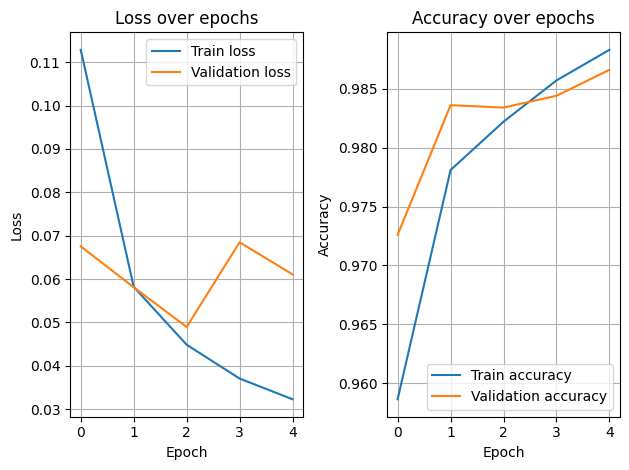

In [37]:
loss, acc = model.evaluate(test_generator, steps=len(test_generator))

print(f"Test accuracy: {acc:.2%}")

plt.subplot(1, 2, 1)

plt.plot(history.history['loss'], label='Train loss')

plt.plot(history.history['val_loss'], label='Validation loss')

plt.title('Loss over epochs')

plt.grid()

plt.xlabel('Epoch')

plt.ylabel('Loss')

plt.legend()

# Криві точності

plt.subplot(1, 2, 2)

plt.plot(history.history['accuracy'], label='Train accuracy')

plt.plot(history.history['val_accuracy'], label='Validation accuracy')

plt.title('Accuracy over epochs')

plt.xlabel('Epoch')

plt.ylabel('Accuracy')

plt.grid()

plt.legend()

plt.tight_layout()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


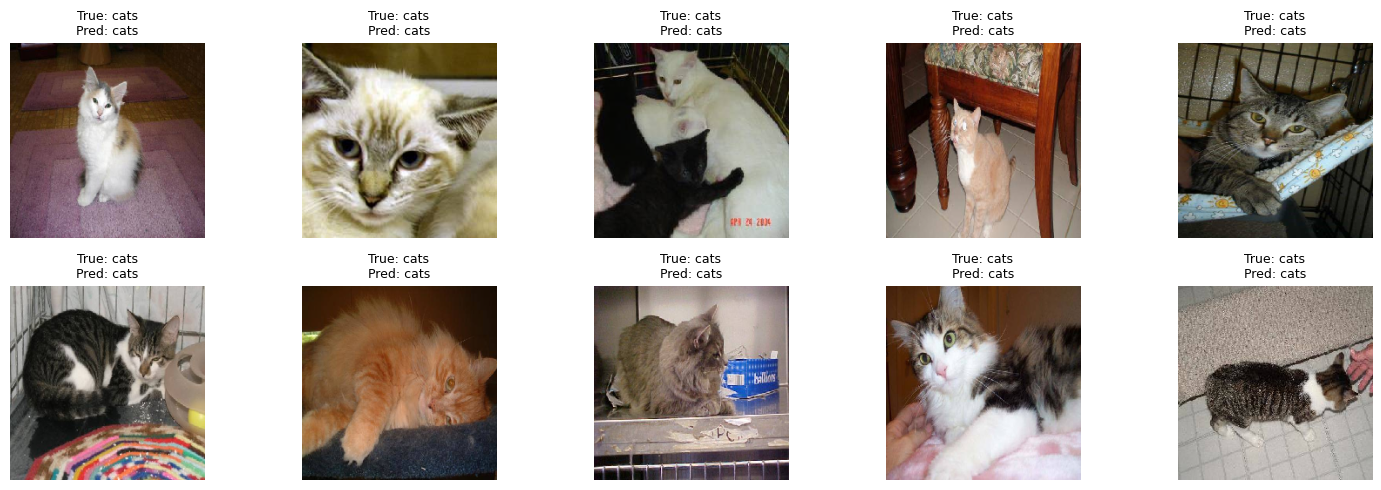

In [38]:
# Повертаємо генератор у початок (на всяк випадок)
test_generator.reset()

# Отримуємо один batch із тестового генератора
images, true_labels = next(test_generator)

# Робимо передбачення
pred_probs = model.predict(images)
pred_labels = (pred_probs > 0.5).astype(int).reshape(-1)

# Отримуємо відповідність індексів класів
inv_class_indices = {v: k for k, v in test_generator.class_indices.items()}
class_names = [inv_class_indices[0], inv_class_indices[1]]  # ['Cat', 'Dog']

# Показуємо перші 10 зображень
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Зображення після VGG16-preprocessing будуть зі зміненими значеннями
    # Повертаємо до нормального вигляду, якщо потрібно
    img = images[i].copy()
    img = img + [103.939, 116.779, 123.68]  # додаємо mean (VGG16)
    img = img[..., ::-1]  # з BGR → RGB
    img = np.clip(img / 255.0, 0, 1)  # для відображення

    plt.imshow(img)
    plt.axis('off')
    true_class = class_names[int(true_labels[i])]
    pred_class = class_names[int(pred_labels[i])]
    plt.title(f"True: {true_class}\nPred: {pred_class}", fontsize=9)
plt.tight_layout()
plt.show()

У роботі реалізовано класифікацію зображень котів і собак за допомогою моделі VGG16. Підготовлено дані, застосовано аугментацію, додано власні шари класифікації. Модель навчено та оцінено точність. Отримано базові навички transfer learning.